## Questions

* Mutual information plots by cell category

In [1]:
cd ~/projects/schwarz/decoder

/home/blansdel/projects/schwarz/decoder


Imports

In [7]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from itertools import combinations, product
from collections import defaultdict
from collections import Counter
from scipy.stats import chi2_contingency
from sklearn.metrics import confusion_matrix 
from collections import defaultdict

from src.lib import compute_stats


Load cell type information

In [8]:
threshold = 0.05
sessions = [2, 6, 7, 9]
str_sessions = [str(x) for x in sessions]
events = ['ReSpout_pos', 'ReSpout_neg', \
       'UnSpout_pos', 'UnSpout_neg', 'ReMid_pos', 'ReMid_neg', 'UnMid_pos', \
       'UnMid_neg']
       
fn_in = './data/input/type_info.csv'
df = pd.read_csv(fn_in)
animals = df.Animal.unique()
n_cond = 3
n_animals = len(animals)
conditions = ['Control', 'Idazoxan', 'Clonidine']
cond_map = {'1':'Control',
           '10':'Control',
           '4':'Idazoxan',
           '50':'Clonidine',
           '80':'Idazoxan',
           '83':'Clonidine',
           'F3':'Idazoxan',
           'F4':'Clonidine',
           'M3':'Control'}
df['treatment'] = df.Animal.map(lambda x: cond_map[x])
fn_in = './data/input/explore2.csv'
df_orig = pd.read_csv(fn_in)
df = pd.merge(df, df_orig[['Animal', 'Session', 'CellID', 'MatchID']], on = ['Animal', 'Session', 'CellID'])
df['CellType'] = df['Type'].astype(str)

In [24]:
def mutual_info(x, y, n_cat = 2, labels = None, return_matrix = False):
    mi = 0
    N = len(x)
    if N == 0: return 0
    assert len(x) == len(y)
    
    if labels is None:
        iterator1 = range(n_cat)
        iterator2 = range(n_cat)
        x = x.astype(int)
        y = y.astype(int)
        if return_matrix:
            mat = np.zeros((n_cat, n_cat))
    else:
        iterator1 = labels 
        iterator2 = labels
        if return_matrix:
            mat = np.zeros((len(labels), len(labels)))

    for idx_i, i in enumerate(iterator1):
        for idx_j, j in enumerate(iterator2):
            pij = sum((x == i) & (y == j))/N
            pi = sum(x == i)/N
            pj = sum(y == j)/N
            if (pij == 0) or (pi == 0) or (pj == 0): continue
            mi += pij*np.log2(pij/pi/pj)
            if return_matrix:
                mat[idx_i, idx_j] = pij

    if return_matrix:
        return mi, mat
    else:
        return mi

Compute mutual information between pairs of days. Shuffle labels 100 times to determine what a baseline MI score to expect, given no relation between labels. Count number of pairs of recordings that have significant mutual information in labels (at alpha level 0.05).

In [25]:
n_reps = 100
alpha = 0.05
mis_all = {}
mis_pvals_all = {}
mis_sig_all = {}
mis_matrices = {}

#Set the random seed in pandas to 42
np.random.seed(42)

for treatment in conditions:
    mis_all[treatment] = {}
    mis_pvals_all[treatment] = {}
    mis_sig_all[treatment] = {}
    mis_matrices[treatment] = {}
    animals = df.loc[df.treatment == treatment, "Animal"].unique()
    for animal in animals:
        df_con = df[(df.treatment == treatment) & (df.Animal == animal)]
        cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, treatment)
        cell_fully_tracked = [k for k,v in cell_stats[animal].items() if np.sum(v[1:]) == 3]
        print("cells tracked throughout 3 recordings", len(cell_fully_tracked), 'out of', len(cell_stats[animal]))
        celltypes = sorted(df_con.CellType.unique())

        mis = np.zeros((4,4))
        mis_pval = np.zeros((4,4))
        mis_sig = np.zeros((4,4))
        mis_matrices[treatment][animal] = {}    
        for i, s_1 in enumerate(sessions):
            for j, s_2 in enumerate(sessions):
                if s_1 == s_2: continue 
                ds1 = df_con.loc[df_con.Session == s_1].set_index('MatchID')
                ds1 = ds1[ds1.index.isin(cell_fully_tracked)]
                ds2 = df_con.loc[df_con.Session == s_2].set_index('MatchID')
                ds2 = ds2[ds2.index.isin(cell_fully_tracked)]
                ds = pd.merge(ds1, ds2, on = 'MatchID')
                mi, mat = mutual_info(ds[f'CellType_x'], ds[f'CellType_y'], labels = celltypes, return_matrix = True)
                #Compute MI null distribution
                null_mis = [mutual_info(ds[f'CellType_x'].values, ds[f'CellType_y'].sample(frac = 1).values, labels = celltypes) for _ in range(n_reps)]
                mis[i,j] = mi
                mis_pval[i,j] = sum(mi < np.array(null_mis))/n_reps
                mis_matrices[treatment][animal][(s_1, s_2)] = mat

        mis_sig_all[treatment][animal] = mis_pval < alpha
        mis_all[treatment][animal] = mis 
        mis_pvals_all[treatment][animal] = mis_pval        

cells tracked throughout 3 recordings 155 out of 489
cells tracked throughout 3 recordings 94 out of 286
cells tracked throughout 3 recordings 276 out of 744
cells tracked throughout 3 recordings 139 out of 733
cells tracked throughout 3 recordings 184 out of 402
cells tracked throughout 3 recordings 193 out of 652
cells tracked throughout 3 recordings 105 out of 277
cells tracked throughout 3 recordings 140 out of 423
cells tracked throughout 3 recordings 439 out of 994


Summarize significant pairs of recording days.

In [16]:

sig_counts = {'Control': defaultdict(int), 'Idazoxan': defaultdict(int), 'Clonidine': defaultdict(int)}
sig_counts_indices = {'Control': defaultdict(int), 'Idazoxan': defaultdict(int), 'Clonidine': defaultdict(int)}
for cond in mis_pvals_all.keys():
    animals = list(mis_pvals_all[cond].keys())
    for animal in animals:
        m = mis_pvals_all[cond][animal]
        indices = zip(*np.where(m <= threshold))
        for idx in indices:
            if idx[0] != idx[1]:
                d1, d2 = idx
                days = (sessions[d1], sessions[d2])
                sig_counts[cond][days] += 1
                sig_counts_indices[cond][(d1, d2)] += 1

heatmaps = {}
for cond in mis_pvals_all.keys():
    heatmaps[cond] = np.zeros((4,4))
    for key, val in sig_counts_indices[cond].items():
        if key[0] > key[1]: continue
        heatmaps[cond][key[0], key[1]] = val


Text(0.5, 0.98, 'Number of days with significant MI in response')

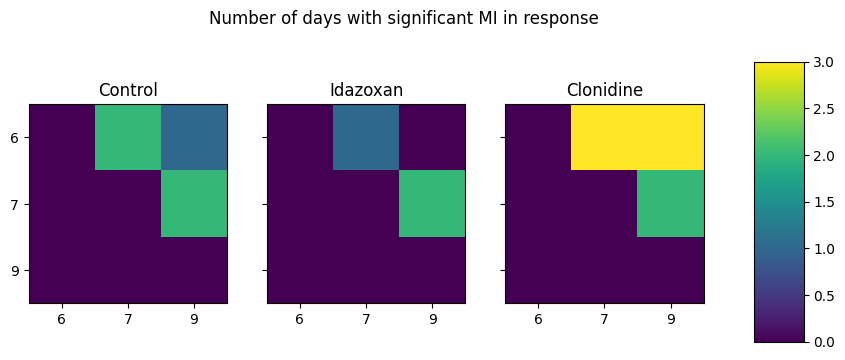

In [17]:
fig, axes = plt.subplots(1,3, figsize = (10,4), sharey = True)
for idx, cond in enumerate(sig_counts_indices.keys()):
    im = axes[idx].imshow(heatmaps[cond][1:,1:], vmin = 0, vmax = 3)
    axes[idx].set_title(cond)        
    axes[idx].set_xticks(range(3))
    axes[idx].set_yticks(range(3))
    axes[idx].set_xticklabels(sessions[1:])
    axes[idx].set_yticklabels(sessions[1:])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.suptitle('Number of days with significant MI in response')

## Illustrative plot of what goes into mutual information calculation

In [27]:
mis_matrices['Control']['1'][6,7]

array([[0.06451613, 0.03225806, 0.01935484, 0.03870968],
       [0.14193548, 0.20645161, 0.15483871, 0.18064516],
       [0.00645161, 0.00645161, 0.01290323, 0.01935484],
       [0.03225806, 0.00645161, 0.02580645, 0.0516129 ]])

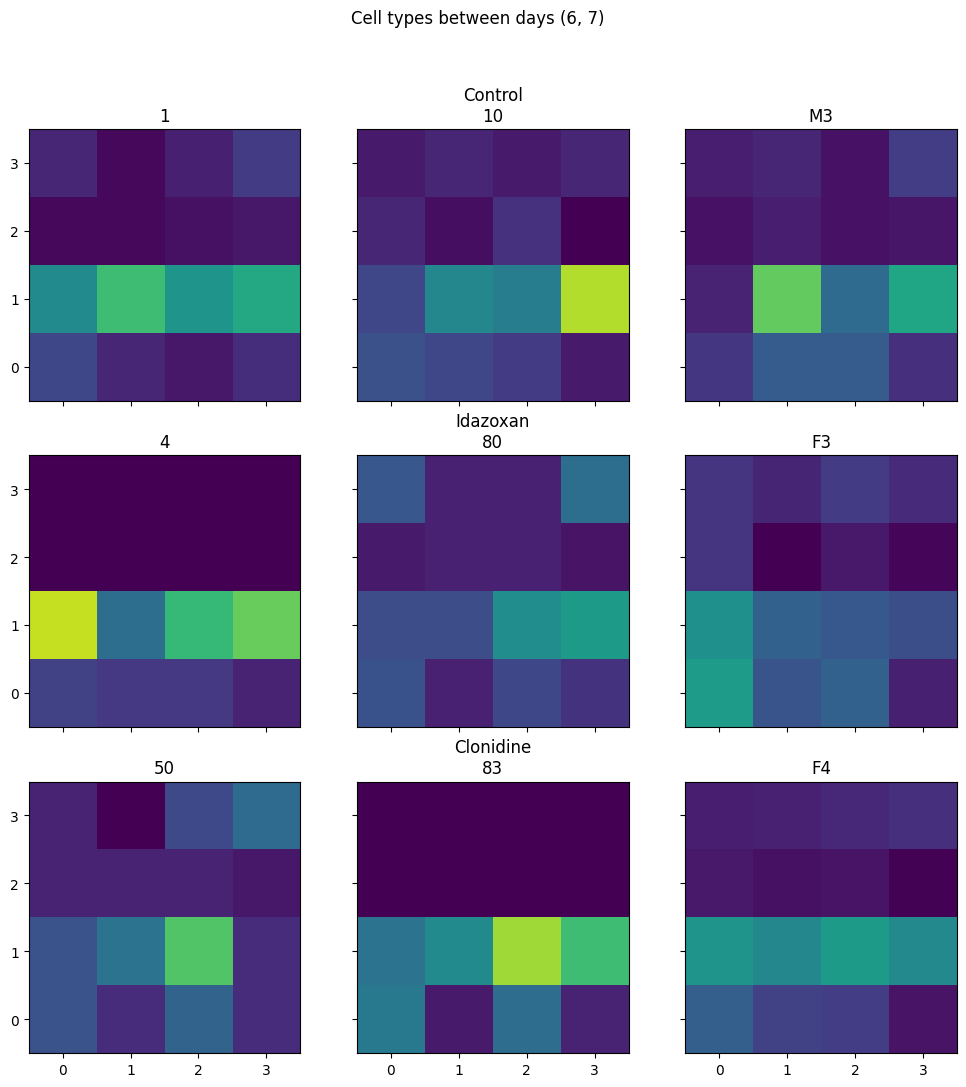

In [39]:
days = (6,7)
conditions = ['Control', 'Idazoxan', 'Clonidine']
fig, axes = plt.subplots(3,3, figsize = (12,12), sharey = True, sharex = True)
fig.suptitle(f'Cell types between days {days}')
for i, cond in enumerate(conditions):
    animals = list(mis_matrices[cond].keys())   
    for j, animal in enumerate(animals):
        axes[i,j].imshow(mis_matrices[cond][animal][days], vmin = 0, vmax = 0.3, origin = 'lower')
        #Set y tick labels to be integers
        axes[i,j].set_yticks(range(4))
        if j == 1:
            axes[i,j].set_title(cond + '\n' + animal)
        else:
            axes[i,j].set_title(animal)